# Stochastic Variational Inference for scalability with SVGP

One of the main criticisms of Gaussian processes is their scalability to large datasets. In this notebook, we illustrate how to use the state-of-the-art Stochastic Variational Gaussian Process (SVGP) (*Hensman, et. al. 2013*) to overcome this problem.

In [1]:
%matplotlib inline
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter

# plt.style.use("ggplot")

# for reproducibility of this notebook:
rng = np.random.RandomState(123)
tf.random.set_seed(42)

## Generating data
For this notebook example, we generate 10,000 noisy observations from a test function:
\begin{equation}
f(x) = \sin(3\pi x) + 0.3\cos(9\pi x) + \frac{\sin(7 \pi x)}{2}
\end{equation}

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)


N = 1000  # Number of training observations

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
data = (X, Y)

We plot the data along with the noiseless generating function:

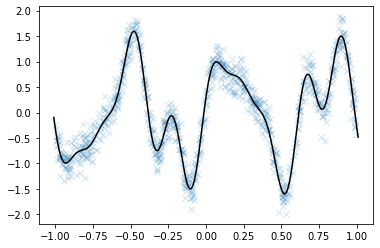

In [6]:
plt.plot(X, Y, "x", alpha=0.2)
Xt = np.linspace(-1.01, 1.01, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, c="k")

## Building the model
The main idea behind SVGP is to approximate the true GP posterior with a GP conditioned on a small set of "inducing" values. This smaller set can be thought of as summarizing the larger dataset. For this example, we will select a set of 50 inducing locations that are initialized from the training dataset:

In [7]:
M = 50  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential()
Z = X[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

2021-11-12 14:00:53.613420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /net/opt/gcc/gcc-11.2/lib64:/net/opt/gcc/gcc-11.2/lib
2021-11-12 14:00:53.613478: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-12 14:00:53.614883: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow

## Likelihood computation: batch vs. minibatch
First we showcase the model's performance using the whole dataset to compute the ELBO.

In [8]:
elbo = tf.function(m.elbo)

In [9]:
# TensorFlow re-traces & compiles a `tf.function`-wrapped method at *every* call if the arguments are numpy arrays instead of tf.Tensors. Hence:
tensor_data = tuple(map(tf.convert_to_tensor, data))
elbo(tensor_data)  # run it once to trace & compile

<tf.Tensor: shape=(), dtype=float64, numpy=-1776.4487307239656>

In [10]:
%%timeit
elbo(tensor_data)

3.44 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can speed up this calculation by using minibatches of the data. For this example, we use minibatches of size 100.

In [11]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

train_iter = iter(train_dataset.batch(minibatch_size))

ground_truth = elbo(tensor_data).numpy()

In [12]:
%%timeit
elbo(next(train_iter))

1.86 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [13]:
evals = [elbo(minibatch).numpy() for minibatch in itertools.islice(train_iter, 100)]

Discrepancy between ground truth and minibatch estimate: -2.0725836950566645


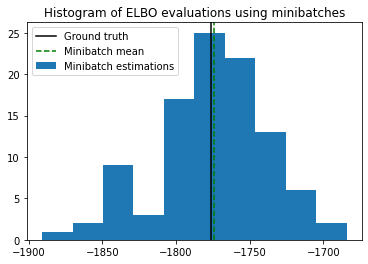

In [14]:
plt.hist(evals, label="Minibatch estimations")
plt.axvline(ground_truth, c="k", label="Ground truth")
plt.axvline(np.mean(evals), c="g", ls="--", label="Minibatch mean")
plt.legend()
plt.title("Histogram of ELBO evaluations using minibatches")
print("Discrepancy between ground truth and minibatch estimate:", ground_truth - np.mean(evals))

### Minibatches speed up computation
The reason for using minibatches is that it decreases the time needed to make an optimization step, because estimating the objective is computationally cheaper with fewer data points. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [15]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_iter = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([elbo(minibatch) for minibatch in itertools.islice(train_iter, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

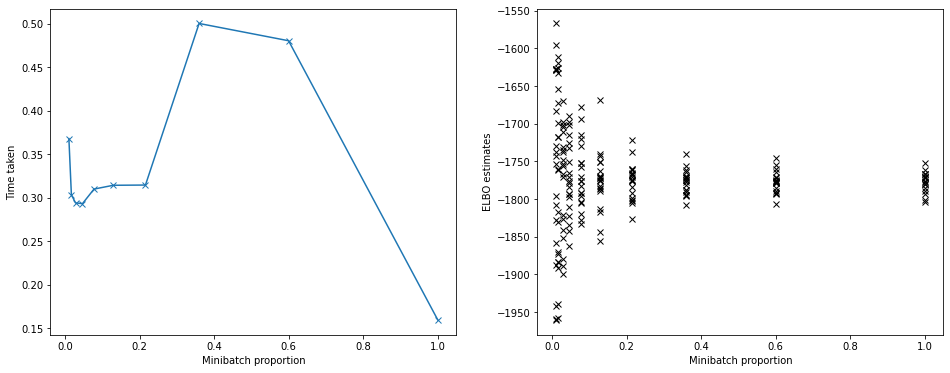

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, "x-")
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), "kx")
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

### Running stochastic optimization

First we create a utility function that plots the model's predictions:

In [26]:
def plot(title=""):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, "x", label="Training points", alpha=0.2)
    (line,) = plt.plot(pX, pY, lw=1.5, label="Prediction")
    # col = line.get_color()
    # plt.fill_between(
    #     pX[:, 0],
    #     (pY - 2 * pYv ** 0.5)[:, 0],
    #     (pY + 2 * pYv ** 0.5)[:, 0],
    #     color=col,
    #     alpha=0.6,
    #     lw=1.5,
    # )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Sparse Points")
    plt.legend(loc="lower right")

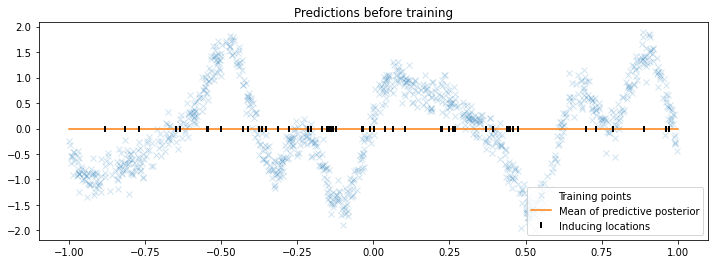

In [18]:



plot(title="Predictions before training")

Now we can train our model. For optimizing the ELBO, we use the Adam Optimizer *(Kingma and Ba 2015)* which is designed for stochastic objective functions. We create a `run_adam` utility function  to perform the optimization.

In [19]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

2021-11-12 14:02:13.334184: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Now we run the optimization loop for 20,000 iterations.

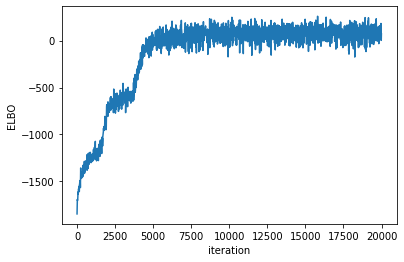

In [20]:
maxiter = ci_niter(20000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

Finally, we plot the model's predictions.

In [24]:
plt.savefig?

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None, metadata=None)

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has n

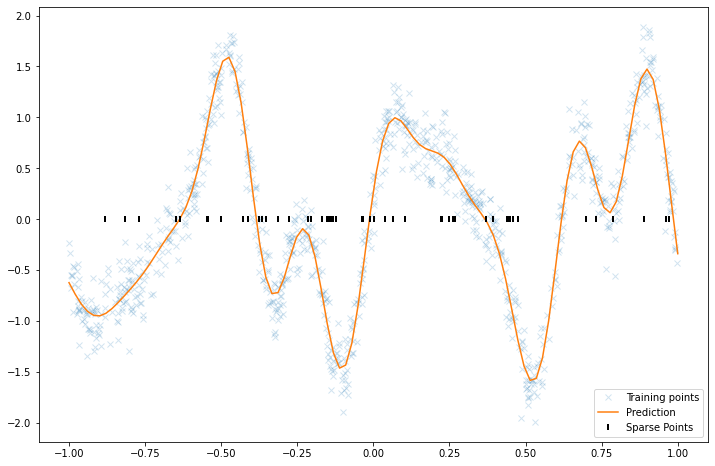

In [27]:
plot("")

plt.savefig('sparse_point.png', dpi=300,bbox_inches='tight' )

## Further reading

Several notebooks expand on this one:

- [Advanced Sparse GP regression](../advanced/advanced_many_points.ipynb), which goes into deeper detail on sparse Gaussian process methods.
- [Optimization](../advanced/optimisation.ipynb) discussing optimizing GP models.
- [Natural gradients](../advanced/natural_gradients.ipynb) for optimizing SVGP models efficiently.

## References:
Hensman, James, Nicolo Fusi, and Neil D. Lawrence. "Gaussian processes for big data." Uncertainty in Artificial Intelligence (2013).

Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).